# Текстовые данные


## Генератор случайного текста

In [ ]:
pip install python-lorem

In [ ]:
import lorem
nonsense = lorem.get_paragraph()
nonsense

##NLTK: Gutenberg corpus
Natural Language ToolKit.

Выборка из библиотеки Гутенберга.

https://www.nltk.org/book/ch02.html

In [ ]:
import nltk
nltk.download(['gutenberg', 'punkt'])
from nltk.corpus import gutenberg

In [ ]:
print('\n'.join(gutenberg.fileids()))

In [ ]:
print(gutenberg.raw('carroll-alice.txt')[:500])

## Деление текста на предложения


### Инструменты языкового анализа


In [ ]:
from nltk.tokenize.punkt import PunktSentenceTokenizer
sentence_tokenizer = PunktSentenceTokenizer()
sentence_tokenizer.tokenize('Hello! World?')

In [ ]:
sentence_tokenizer.tokenize(nonsense)

### Информация в первоисточнике

In [ ]:
[lorem.get_sentence() for _ in range(5)]

In [ ]:
gutenberg.sents('carroll-alice.txt')[:2]

## Деление текста на слова


In [ ]:
from nltk import word_tokenize, wordpunct_tokenize
import re
"hello world".split(), re.split("\s", "hello world"), word_tokenize("hello world"), wordpunct_tokenize("hello world")

In [ ]:
for f in str.split, re.compile("\s").split, word_tokenize, wordpunct_tokenize:
  print(f(nonsense))

In [ ]:
import re
word_re = re.compile('\w+|[^\w\s]+')

print('source', len(gutenberg.words('carroll-alice.txt')))
print('split', len(gutenberg.raw('carroll-alice.txt').split()))
print('word_tokenize', len(word_tokenize(gutenberg.raw('carroll-alice.txt'))))
print('wordpunkt_tokenize', len(wordpunct_tokenize(gutenberg.raw('carroll-alice.txt'))))
print('regular expression', len(word_re.findall(gutenberg.raw('carroll-alice.txt'))))

In [ ]:
print('source', gutenberg.words('carroll-alice.txt')[:50])
print()
print('split', gutenberg.raw('carroll-alice.txt').split()[:50])
print('word_tokenize', word_tokenize(gutenberg.raw('carroll-alice.txt'))[:50])
print('wordpunkt_tokenize', wordpunct_tokenize(gutenberg.raw('carroll-alice.txt'))[:50])
print('regular expression', word_re.findall(gutenberg.raw('carroll-alice.txt'))[:50])

# Задача: подсчёт популярности слов
Разобъем входные данные на подстроки для обработки по частям.

In [ ]:
alice_lines = gutenberg.raw('carroll-alice.txt').splitlines()
alice_lines[123]

## Просто цикл ("классический" подход)

In [ ]:
counts = {}

for line in alice_lines:
    words = wordpunct_tokenize(line)

    for word in words:
        word = word.lower()
        counts[word] = counts.get(word, 0) + 1

print(counts)
print(sum(counts.values()))
list(
    reversed(
        sorted((n, word) for word, n in counts.items())
    )
)[:10]

## Идиоматический Питон


In [ ]:
print(alice_lines[0])
words = [w for line in alice_lines for w in wordpunct_tokenize(line)]
print(words[:50])
lower_words = [w.lower() for w in words]
print(lower_words[:50])
print(len(lower_words))

In [ ]:
from collections import Counter

counts = Counter(lower_words)
print(sum(counts.values()))
counts.most_common(10)


In [ ]:
Counter(w.lower() for line in alice_lines for w in wordpunct_tokenize(line)).most_common(10)

In [ ]:
import operator
from functools import reduce

print(alice_lines[0])
words = [[w for w in wordpunct_tokenize(line)] for line in alice_lines]
print(words[:4])
lower_words = [[w.lower() for w in line] for line in words]
print(lower_words[:4])
counters = [Counter(line) for line in lower_words]
print(counters)
reduce(operator.add, counters, Counter()).most_common(10)


## Функциональный подход

In [ ]:
from itertools import chain

word_lists = map(wordpunct_tokenize, alice_lines)
#print(list(word_lists)[:3])
words = chain(*word_lists)
#print(list(words)[:20])
lower_words = map(str.lower, words)
#print(list(lower_words)[:10])
Counter(lower_words).most_common(10)

In [ ]:
word_lists = list(map(wordpunct_tokenize, alice_lines))
print(word_lists[:4])
lower_words = list(map(
    lambda line_words: [w.lower() for w in line_words],
    word_lists
))
print(lower_words[:4])
counters = map(Counter, lower_words)
reduce(operator.add, counters, Counter()).most_common(10)

## Удобные свойства map и reduce:

Если функция чистая, то мап можно вызывать параллельно

In [ ]:
from multiprocessing import Pool
print(list(map(str, [1, 2, 3, 4, 5, 6])))
with Pool() as pool:
  print(pool.map(str, [1, 2, 3, 4, 5, 6]))

Если reduce действительно работает как reduce, то его можно вызывать от результата других вызовов reduce

In [ ]:
from functools import reduce
def add(s, x):
  return s + x
print(reduce(add, range(10)))
print(reduce(add, 
       [
        reduce(add, range(3)), 
        reduce(add, range(3,6)),
        reduce(add, range(6,10))
       ]
))

In [ ]:
def count(s, x):
  return s + 1
print(reduce(count, range(10)))
print(reduce(count, 
       [
        reduce(count, range(3), 0), 
        reduce(count, range(3,6), 0),
        reduce(count, range(6,10), 0)
       ]
      , 0)
)

## Локальный MapReduce
https://towardsdatascience.com/a-beginners-introduction-into-mapreduce-2c912bb5e6ac

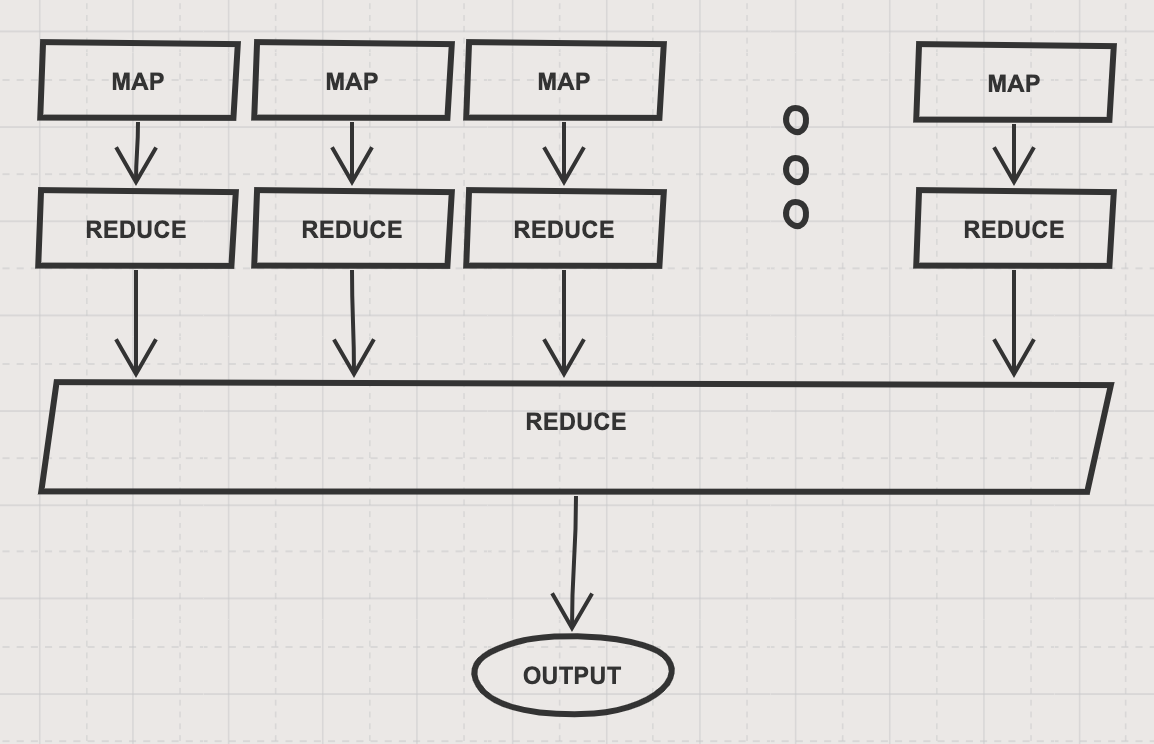

In [ ]:
from typing import List, Iterable
def wordcounter(s: str) -> Counter:
  return Counter(map(str.lower, wordpunct_tokenize(s)))

def reduce_counters(counters: Iterable[Counter]) -> Counter:
  return reduce(operator.add, counters, Counter())

wordcounter("Hello world!")

In [ ]:
%time reduce_counters(map(wordcounter, alice_lines)).most_common(10)

In [ ]:
from multiprocessing import Pool

with Pool() as pool:
  %time reduce_counters(pool.map(wordcounter, alice_lines)).most_common(10)

In [ ]:
def word_counters(s: str) -> List[Counter]:
  return [Counter([w.lower()]) for w in wordpunct_tokenize(s)]

word_counters("Hello world!")

In [ ]:
def wordcount_local(texts: Iterable[str]) -> Counter:
    return reduce_counters(
        map(reduce_counters,
            map(word_counters,
                texts)
        )
    )

In [ ]:
%time wordcount_local(alice_lines).most_common(10)

In [ ]:
much_nonsense = [lorem.get_paragraph() for _ in range(40)]
%timeit wordcount_local(much_nonsense).most_common(10)

In [ ]:
def wordcount_local_mp(texts: Iterable[str]) -> Counter:
  with Pool() as pool:
    return reduce_counters(
      pool.map(reduce_counters,
        pool.map(word_counters,
          texts)
      )
  )

In [ ]:
%timeit wordcount_local_mp(much_nonsense).most_common(10)

# Простой "распределенный" MapReduce

https://ru.wikipedia.org/wiki/MapReduce

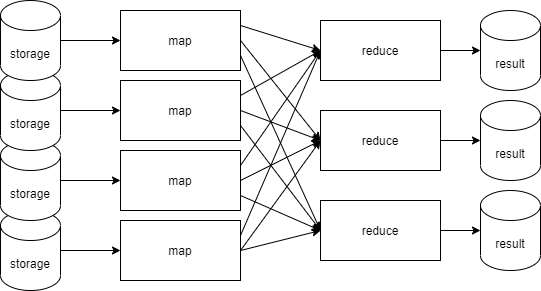

Принцип обработки данных
```
[записи]
-> Map ->
[(k1, v11), (k2, v21), (k1, v12) ...]
-> Shuffle ->
{k1: [v11, v12, ...]), k2: [v21, ...], ...}
-> Reduce ->
{k1: V1, k2: V2, ...}
```

Действие функций mapper и reducer, решающих задачу:

`запись -> mapper -> [(k1, v1), (k2, v2), (k1, v3) ...]`

`[v1, v3, ...] -> reducer -> V`

## Map

In [ ]:
from typing import List, Tuple
def count_words_mapper(line: str) -> List[Tuple[str, int]]:
  return [(w, 1) for w in wordpunct_tokenize(line)]

In [ ]:
count_words_mapper("hello world")

In [ ]:
list(map(count_words_mapper,
         ["hello world", "hello me"]
         ))

In [ ]:
from typing import Callable

def map_layer(mapper: Callable) -> Callable:
  def inner(records: Iterable) -> List[Tuple]:
    return [(k, v) for r in records for k, v in mapper(r)]
  return inner

word_counters = map_layer(count_words_mapper)

In [ ]:
word_counters( ["hello world", "hello me"])

In [ ]:
list(word_counters(alice_lines))[:20]

## Merge by key


In [ ]:
from typing import Dict, Any
from collections import defaultdict

def merge_layer(pairs: List[Tuple]) -> Dict[Any, List]:
  result = defaultdict(list)
  for k, v in pairs:
    result[k].append(v)
  return dict(result)

merge_layer([('a', 1), ('b', 2), ('c', 3), ('a', 4), ('a', 5), ('x', 6), ('y', 7)])

In [ ]:
from itertools import islice
merge_layer(word_counters(islice(alice_lines, 20)))

## Reduce

`[v1, v3, ...] -> reducer -> V`

`{k1: [v11, v12, ...]), k2: [v21, ...], ...} -> Reduce -> {k1: V1, k2: V2, ...}`

In [ ]:
from typing import Generator
def reduce_layer(reducer: Callable) -> Callable:
  def inner(merged: Dict[Any, List]) -> Dict:
    return {k: reducer(v) for k, v in merged.items()}
  return inner

counter_adder = reduce_layer(sum)

alice_wordcounts = counter_adder(merge_layer(word_counters(alice_lines)))

print(alice_wordcounts)

In [ ]:
sorted(alice_wordcounts.items(), key=lambda pair: -pair[1])[:20]

## Собираем

In [ ]:
import pandas as pd

def simple_job(mapper: Callable, reducer:Callable) -> Callable:
  m = map_layer(mapper)
  r = reduce_layer(reducer)
  def inner(records: List) -> Dict:
    return dict(r(merge_layer(m(records))))
  return inner

wordcounter = simple_job(
    lambda f: ((token, 1) for token in word_tokenize(f)),
    sum)
gutenberg_raw = [gutenberg.raw(f) for f in gutenberg.fileids()]

%time result = wordcounter(gutenberg_raw)

pass
sorted(result.items(), key=lambda pair: -pair[1])[:20]


In [ ]:
import pandas as pd
df = pd.DataFrame(result.items(), columns=["word", "occurences"])
df

In [ ]:
df[df.occurences>5000].sort_values('occurences').plot(x='word', y='occurences', kind='barh', figsize=(16, 12))

In [ ]:
%timeit wordcounter(much_nonsense)

In [ ]:
def mapper(numbers: List[int]) -> Tuple[str, int]:
  return [('total', sum(numbers)), ('count', len(numbers))]

# Иногда логика редюсера должна зависеть от ключа
# На этот раз нам повезло
def reducer(values: Iterable[int]) -> int:
  return sum(values)

average =  simple_job(
    mapper,
    reducer
)

result = average([[1, 2, 3, 1, 2, 3], [10, -10]])
print(result)
result['total']/result['count']
# Не всегда можно получить ответ за один mapreduce!

In [ ]:
def mapper2(numbers: List[int]) -> Tuple[str, Tuple[int, int]]:
  return [('average', (sum(numbers), len(numbers)))]
# Почему бы не вернуть в ответе кортеж-пару в качестве значения?

def reducer2(values: Iterable[Tuple[int, int]]):
  total = sum(pair[0] for pair in values)
  count = sum(pair[1] for pair in values)
  return total/count

average2 = simple_job(
    mapper2,
    reducer2
)

average2([[1, 2, 3, 1, 2, 3], [10, -10]])

## Задание

1. Посчитать суммарное количество слов в `gutenberg_raw` (через `simple_job`)

2. Посчитать суммарное количество слов и суммарное количество предложений одним запуском `simple_job(...)(gutenberg_raw)`

3. Найти (с помощью `simple_job`) самое длинное предложение в gutenberg_raw

4. Посчитать с помощью `simple_job` гистограмму распределения длины предложений (в словах) по датасету `sent_tokenize(gutenberg.raw('carroll-alice.txt'))`. То есть какие предложения в тексте встречаются наиболее часто? 

  Потом эти данные можно собрать в pandas DataFrame и визуализировать. Как правильно визуализировать заранее просчитанную гистограмму, см. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

  Подсказка: 
  - Вариант 1. Ключом может быть номер ячейки гистограммы. Тогда размер ячеек нужно задать заранее.
  - Вариант 2. Можно посчитать из каждого предложения целую гистограмму. Параметры гистограммы тоже придётся задавать заранее.
  - Вариант 3. Сделать ключом длину предложения. Проще всего с точки зрения map и reduce, но не до конца решает задачу (потребует дополнительной обработки результата).


# Hadoop MapReduce

https://hadoop.apache.org/docs/current/hadoop-mapreduce-client/hadoop-mapreduce-client-core/MapReduceTutorial.html#Job_Configuration

- InputFormat
- Mapper
- combiner (если есть) - локальный пре-Reducer
- Partitioner - управляет shuffle
- Reducer
- OutputFormat

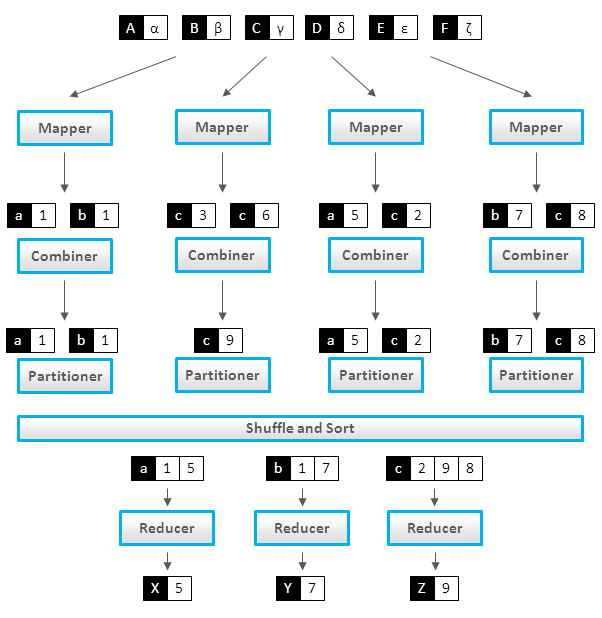

https://highlyscalable.wordpress.com/2012/02/01/mapreduce-patterns/

## Input, output

```
'uri' -> file(s) -> InputSplit
InputFormat.createRecordReader(InputSplit) -> RecordReader

RecordReader.nextKeyValue()
RecordReader.getCurrentKey()
RecordReader.getCurrentValue()
OutputFormat.getRecordWriter(jobconf) -> OutputWriter
```
Главное:
- работа всегда идёт с парами ключ-значение
- и данные и вычисления распределены по кластеру

In [ ]:
from nltk.corpus import gutenberg
gutenberg_split = [[(f, gutenberg.raw(f))] for f in gutenberg.fileids()]

[[(k, len(v)) for k,v in node_records] for node_records in gutenberg_split]

In [ ]:
gutenberg_lines = [list(enumerate(gutenberg.raw(f).splitlines())) for f in gutenberg.fileids()]

gutenberg_lines[7][:10]


In [ ]:
def lorem_texts(nodes:int=4, records:int=4, size:int=3) -> List[List[Tuple[Tuple[int, int], str]]]:
  return [[(i*records+j, lorem.get_paragraph(count=size)) for j in range(records)] for i in range(nodes)]

lorem_texts()

## Mapper
`(k,v) -> [(k1, v1), (k2, v2), ...]`

In [ ]:
from typing import TypeVar

# ignoring k
def word_counts(k:Any, text:str) -> List[Tuple[str, int]]:
  return [(word, 1) for word in word_tokenize(text)]

T = TypeVar('T')

def len_mapper(k: T, text) -> List[Tuple[T, int]]:
  return [(k, len(text))]

[[len_mapper(k, v) for k, v in local_records] for local_records in gutenberg_split]


In [ ]:
records = [('a', 1), ('b', 2), ('c', 3)]
print(list(zip(*records)))

In [ ]:
list(map(lambda k, v: (k, v), ('a', 'b', 'c'), (1, 2, 3)))

In [ ]:
def map_local(mapper: Callable) -> Callable:
  def inner(records: Iterable[Tuple]) -> List:
    return [pair for k, v in records for pair in mapper(k, v)]
  return inner

def double(k, v) -> List[Tuple]:
  return [(k, v)] * 2

print(f"double('a', 1)=", double('a', 1))

print(records, " -> map_local(double) -> ", map_local(double)(records))


## Merge by key


In [ ]:
K = TypeVar('K')
V = TypeVar('V')

def merge(pairs: Tuple[K, V]) -> List[Tuple[K, List[V]]]:
  result = defaultdict(list)
  for k, v in pairs:
    result[k] = result[k] + [v]
  return list(result.items())

records = [('a', 1), ('b', 2), ('c', 3), ('a', 4), ('a', 5), ('x', 6), ('y', 7)]

print(f'merge({records}) = ', merge(records))

In [ ]:
def merge_nodes(pairs_by_node: List[List[Tuple[K, V]]]) -> List[List[Tuple[K, List[V]]]]:
  return list(map(merge, pairs_by_node))

merge_nodes([[('a', 1), ('b', 2), ('c', 3)],
         [('a', 4), ('a', 5)],
         [('x', 6), ('y', 7)]])

## Reducer, Combiner
`(k, [v1, v2, v3]) -> [(k1, w1), (k2, w2), ...]`

In [ ]:
def summer(k: K, values: List[V]) -> List[Tuple[K, Any]]:
  return [(k, sum(values))]

summer('x', range(10))

In [ ]:
local_data = [('a', [1, 2, 3]), ('b', [2])]

print(f"summer('a', [1,2,3])=", summer('a', [1,2,3]))

print(local_data, " -> map_local(summer) -> ", map_local(summer)(local_data))


## Partitioner
На какой узел направлять данные при shuffle?

`(k, v, Np) -> p`

In [ ]:
print(hash('a'))
print(hash('b'))
print(hash(1))

In [ ]:
-123%10

In [ ]:
from typing import Hashable
def hash_partitioner(k:Hashable, v:int, N:int) -> int:
  return hash(k)%N
data = "Hello World!"
list(zip(data, [hash_partitioner(c, 'whatever', 7) for c in data]))

## Shuffle

In [ ]:
def shuffle(pairs_by_node: List[List[Tuple[K, V]]], Np: int, partitioner:Callable[[K, int, int], int]=hash_partitioner) -> List[List[Tuple[K, List[V]]]]:
  partitions = [defaultdict(list) for _ in range(Np)]
  for pairs in pairs_by_node:
    for k, v in pairs:
      partition = partitions[partitioner(k, v, Np)]
      partition[k].append(v)
  return [[(k, values) for k, values in d.items()] for d in partitions]

shuffle([[('a', 1), ('b', 2), ('c', 3)],
         [('a', 4), ('a', 5)],
         [('x', 6), ('y', 7)]],
        4)

## Собираем

In [ ]:
def describe(name: str, value: Any) -> None:
  if hasattr(value, '__len__'):
    print(f'{name} is a {type(value).__name__} of length {len(value)}')
  else:
    print(f'{name} is a {type(value).__name__}')
  
def debug(name: str, v: List) -> None:
  describe(name, v)
  for i, u in enumerate(v):
    if len(u):
      describe(name + f'[{i}]', u)
      print(f'{name}[{i}][0] = {str(u[0])[:100]}')
      return
  i = 0
  u = v[0]
  describe(name + f'[{i}]', u)
  describe(name + f'[{i}][0]', u[0])
  print(f'{v}[{i}][0] = {str(u[0])[:100]}')
  
def hadooplike_job(mapper:Callable, reducer:Callable=None, combiner:Callable=None, to_nodes:int=4) -> Callable:
  def inner(input: List[List[Tuple]]) -> List[List[Tuple]]:
    debug('input', input)
    mapped = list(map(map_local(mapper), input))
    debug('mapped', mapped)
    if reducer is None:
      return mapped

    if combiner:
      merged = list(map(merge, mapped))
      debug('merged', merged)
      combined = list(map(map_local(combiner), merged))
      debug('combined', combined)

    else:
      combined = mapped

    shuffled = shuffle(combined, to_nodes)
    debug('shuffled', shuffled)
    reduced = list(map(map_local(reducer), shuffled))
    debug('reduced', reduced)
    return reduced
  return inner


In [ ]:
wordcounter = hadooplike_job(word_counts, summer, summer, 4)

result = wordcounter(lorem_texts())
pass
pd.DataFrame(chain(*result), columns=["word", "occurences"]).sort_values("occurences").tail(10)

In [ ]:
%time result = wordcounter(gutenberg_split)
pd.DataFrame(chain(*result), columns=["word", "occurences"]).sort_values("occurences").tail(10)

## Задание
5. Переписать mapper и reducer из заданий 1-4 для hadooplike_job, проверить, что логика их работы такая же. Меняется ли ответ, если использовать редюсер и в качестве комбайнера тоже?